In [14]:
# imports
import torch
from torch import nn
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import MNIST # Training dataset
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
#####################
# target model
from net_ import target_net

if torch.cuda.is_available():  
    dev = 'cuda:0'
else:  
    dev = 'cpu'

print('device: ', dev)

def show_tensor_images(image_tensor, num_images=25):
    image_tensor = image_tensor.reshape(image_tensor.shape[0],1,28,28).cpu().detach()
    size = (1,28,28)
    image_unflat = image_tensor.detach().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

device:  cuda:0


In [15]:
# obtain mnist data and process
batch_size = 128
num_of_classes = 10

def get_indices(dataset,ind_array):
    indices =  []
    for i in range(len(dataset.targets)):
        for ind in ind_array:
            if dataset.targets[i] == ind:
                indices.append(i)
    return indices

dataset = MNIST('.', train=True, download=False,transform=transforms.ToTensor())
dataset_test = MNIST('.', train=False, download=False,transform=transforms.ToTensor())

idx = get_indices(dataset, np.arange(num_of_classes))
idx_test = get_indices(dataset_test, np.arange(num_of_classes))
data_loader_target = DataLoader(dataset, batch_size=batch_size, sampler = SubsetRandomSampler(idx))
data_loader_altered = DataLoader(dataset_test, batch_size=1000, sampler = SubsetRandomSampler(idx_test))

classes = np.arange(num_of_classes)

In [3]:
%%time 

net = target_net(num_of_classes).to(dev)
criterion_tar = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

PATH = './target_models/ff_net_'+str(num_of_classes)+'classes_device-'+dev+'.pth'
# train and and save the model
#net.train(data_loader_target, criterion_tar, optimizer,device=dev)
#torch.save(net.state_dict(), PATH)
# load the model
net = target_net(num_of_classes).to(dev)
net.load_state_dict(torch.load(PATH))

print('model accuracy: ', net.accuracy(data_loader_target,dev))

model accuracy:  98.68666666666667
CPU times: user 9.19 s, sys: 1.07 s, total: 10.3 s
Wall time: 10.3 s


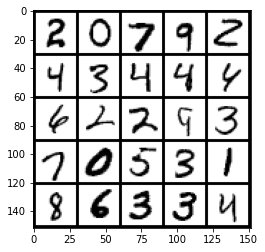

accuracy (DNN) on inverted:  3.56 %


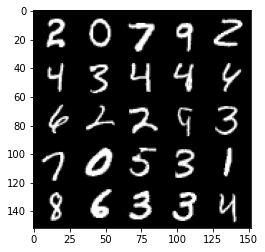

accuracy (DNN) on normal:  97.71 %


In [4]:
# inversion (DNN)
correct_dir = 0.
total_dir = 0.
correct_ = 0.
total = 0.
for data in data_loader_altered:
    x,y = data
    x_ = 1.-x
    predicted_dir = torch.argmax(net(x_.reshape(x_.shape[0],28*28).to(dev)),dim=1)
    correct_dir += (predicted_dir == y.to(dev)).sum().item()
    predicted_ = torch.argmax(net(x.reshape(x.shape[0],28*28).to(dev)),dim=1)
    correct_ += (predicted_ == y.to(dev)).sum().item()
    total += len(y)
show_tensor_images(x_)
print('accuracy (DNN) on inverted: ',round((correct_dir/total)*100.,5),'%')
show_tensor_images(x)
print('accuracy (DNN) on normal: ',round((correct_/total)*100.,5),'%')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


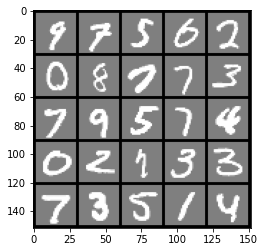

accuracy (DNN) on half-caff:  97.57 %


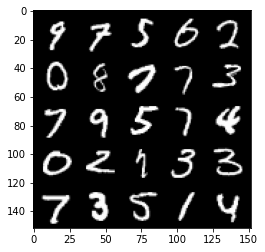

accuracy (DNN) on normal:  97.57 %


In [5]:
# half caff (DNN)
correct_dir = 0.
total_dir = 0.
correct_ = 0.
total = 0.
for data in data_loader_altered:
    x,y = data
    x_ = x + 0.5
    predicted_dir = torch.argmax(net(x_.reshape(x_.shape[0],28*28).to(dev)),dim=1)
    correct_dir += (predicted_dir == y.to(dev)).sum().item()
    predicted_ = torch.argmax(net(x.reshape(x.shape[0],28*28).to(dev)),dim=1)
    correct_ += (predicted_ == y.to(dev)).sum().item()
    total += len(y)
show_tensor_images(x_)
print('accuracy (DNN) on half-caff: ',round((correct_dir/total)*100.,5),'%')
show_tensor_images(x)
print('accuracy (DNN) on normal: ',round((correct_/total)*100.,5),'%')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


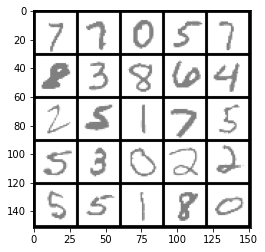

accuracy (DNN) on inverted half-caff:  3.6 %


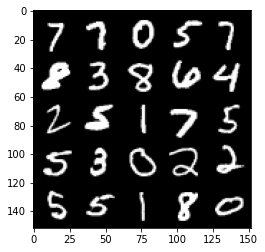

accuracy (DNN) on normal:  97.61 %


In [6]:
# inversion + half-caff (DNN)
correct_dir = 0.
total_dir = 0.
correct_ = 0.
total = 0.
for data in data_loader_altered:
    x,y = data
    x_ = 1.5-x
    predicted_dir = torch.argmax(net(x_.reshape(x_.shape[0],28*28).to(dev)),dim=1)
    correct_dir += (predicted_dir == y.to(dev)).sum().item()
    predicted_ = torch.argmax(net(x.reshape(x.shape[0],28*28).to(dev)),dim=1)
    correct_ += (predicted_ == y.to(dev)).sum().item()
    total += len(y)
show_tensor_images(x_)
print('accuracy (DNN) on inverted half-caff: ',round((correct_dir/total)*100.,5),'%')
show_tensor_images(x)
print('accuracy (DNN) on normal: ',round((correct_/total)*100.,5),'%')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


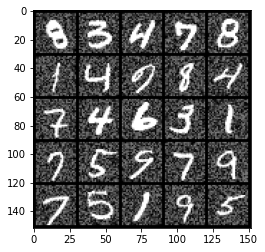

accuracy (DNN) on inverted:  95.86 %


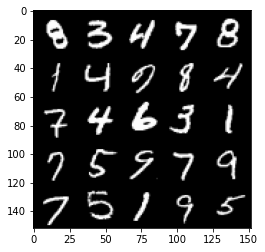

accuracy (DNN) on normal:  97.67 %


In [7]:
# noise from [0,.5) (DNN)
correct_dir = 0.
total_dir = 0.
correct_ = 0.
total = 0.
for data in data_loader_altered:
    x,y = data
    x_ = x + 0.5*torch.rand(x.shape)
    predicted_dir = torch.argmax(net(x_.reshape(x_.shape[0],28*28).to(dev)),dim=1)
    correct_dir += (predicted_dir == y.to(dev)).sum().item()
    predicted_ = torch.argmax(net(x.reshape(x.shape[0],28*28).to(dev)),dim=1)
    correct_ += (predicted_ == y.to(dev)).sum().item()
    total += len(y)
show_tensor_images(x_)
print('accuracy (DNN) on inverted: ',round((correct_dir/total)*100.,5),'%')
show_tensor_images(x)
print('accuracy (DNN) on normal: ',round((correct_/total)*100.,5),'%')

In [16]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = torch.sigmoid(x)
        return output


    def train(self, device, train_loader, optimizer, n_epochs):
        for epoch in range(75):
            for batch_idx, (data, target) in enumerate(train_loader):
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output = self.forward(data)
                loss = criterion_tar(output, target)
                loss.backward()
                optimizer.step()
            if True: #(epoch+1)%5 == 0:
                print('epoch/epochs: '+str(epoch+1)+'/'+str(n_epochs))
                print('accuracy: ', (torch.argmax(output,dim=1) == target).sum().item()/len(target))
                print('-----------------------------------')

netc = Net().to(dev)
optimizer = optim.SGD(netc.parameters(), lr=0.001, momentum=0.9)
netc.train(dev,data_loader_target,optimizer,25)

epoch/epochs: 1/25
accuracy:  0.46875
-----------------------------------
epoch/epochs: 2/25
accuracy:  0.8020833333333334
-----------------------------------
epoch/epochs: 3/25
accuracy:  0.84375
-----------------------------------
epoch/epochs: 4/25
accuracy:  0.7916666666666666
-----------------------------------
epoch/epochs: 5/25
accuracy:  0.84375
-----------------------------------
epoch/epochs: 6/25
accuracy:  0.90625
-----------------------------------
epoch/epochs: 7/25
accuracy:  0.875
-----------------------------------
epoch/epochs: 8/25
accuracy:  0.9166666666666666
-----------------------------------
epoch/epochs: 9/25
accuracy:  0.8333333333333334
-----------------------------------
epoch/epochs: 10/25
accuracy:  0.9166666666666666
-----------------------------------
epoch/epochs: 11/25
accuracy:  0.8958333333333334
-----------------------------------
epoch/epochs: 12/25
accuracy:  0.90625
-----------------------------------
epoch/epochs: 13/25
accuracy:  0.885416666666

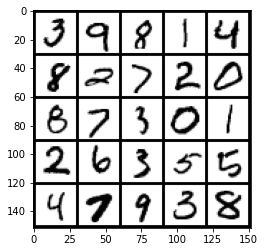

accuracy (CNN) on inverted:  4.13 %


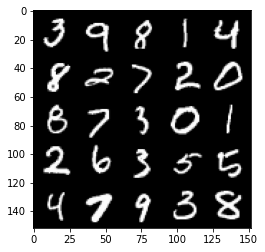

accuracy (CNN) on normal:  94.16 %


In [17]:
# inversion data (CNN)
correct_dir = 0.
total_dir = 0.
correct_ = 0.
total = 0.
for data in data_loader_altered:
    x,y = data
    x_ = 1.-x
    predicted_dir = torch.argmax(netc(x_.to(dev)),dim=1)
    correct_dir += (predicted_dir == y.to(dev)).sum().item()
    predicted_ = torch.argmax(netc(x.to(dev)),dim=1)
    correct_ += (predicted_ == y.to(dev)).sum().item()
    total += len(y)
show_tensor_images(x_)
print('accuracy (CNN) on inverted: ',round((correct_dir/total)*100.,5),'%')
show_tensor_images(x)
print('accuracy (CNN) on normal: ',round((correct_/total)*100.,5),'%')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


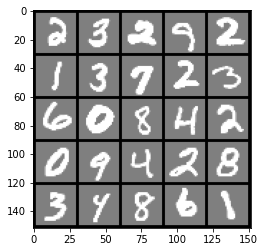

accuracy (CNN) on half-caff:  44.62 %


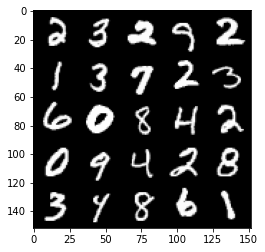

accuracy (CNN) on normal:  94.39 %


In [18]:
# half caff data (CNN)
correct_dir = 0.
total_dir = 0.
correct_ = 0.
total = 0.
for data in data_loader_altered:
    x,y = data
    x_ = x + 0.5
    predicted_dir = torch.argmax(netc(x_.to(dev)),dim=1)
    correct_dir += (predicted_dir == y.to(dev)).sum().item()
    predicted_ = torch.argmax(netc(x.to(dev)),dim=1)
    correct_ += (predicted_ == y.to(dev)).sum().item()
    total += len(y)
show_tensor_images(x_)
print('accuracy (CNN) on half-caff: ',round((correct_dir/total)*100.,5),'%')
show_tensor_images(x)
print('accuracy (CNN) on normal: ',round((correct_/total)*100.,5),'%')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


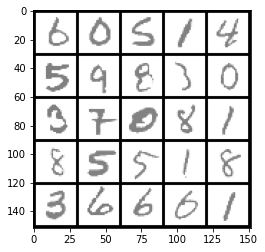

accuracy (CNN) on inverted half-caff:  4.59 %


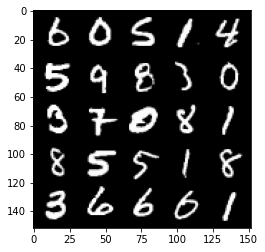

accuracy (CNN) on normal:  94.44 %


In [19]:
# inversion + half-caff data (CNN)
correct_dir = 0.
total_dir = 0.
correct_ = 0.
total = 0.
for data in data_loader_altered:
    x,y = data
    x_ = 1.5-x
    predicted_dir = torch.argmax(netc(x_.to(dev)),dim=1)
    correct_dir += (predicted_dir == y.to(dev)).sum().item()
    predicted_ = torch.argmax(netc(x.to(dev)),dim=1)
    correct_ += (predicted_ == y.to(dev)).sum().item()
    total += len(y)
show_tensor_images(x_)
print('accuracy (CNN) on inverted half-caff: ',round((correct_dir/total)*100.,5),'%')
show_tensor_images(x)
print('accuracy (CNN) on normal: ',round((correct_/total)*100.,5),'%')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


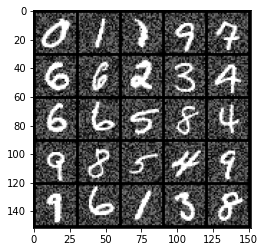

accuracy (CNN) on noisey:  62.94 %


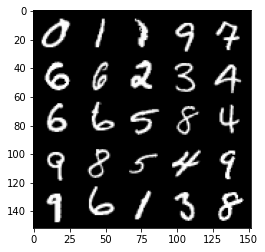

accuracy (CNN) on normal:  94.39 %


In [20]:
# noise on [0,.5) data (CNN)
correct_dir = 0.
total_dir = 0.
correct_ = 0.
total = 0.
for data in data_loader_altered:
    x,y = data
    x_ = x + 0.5*torch.rand(x.shape)
    predicted_dir = torch.argmax(netc(x_.to(dev)),dim=1)
    correct_dir += (predicted_dir == y.to(dev)).sum().item()
    predicted_ = torch.argmax(netc(x.to(dev)),dim=1)
    correct_ += (predicted_ == y.to(dev)).sum().item()
    total += len(y)
show_tensor_images(x_)
print('accuracy (CNN) on noisey: ',round((correct_dir/total)*100.,5),'%')
show_tensor_images(x)
print('accuracy (CNN) on normal: ',round((correct_/total)*100.,5),'%')